In [1]:
# Standard library imports
import math
import logging
from collections.abc import Mapping
from operator import attrgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn, tensor, optim
from torchvision import datasets
from torch.utils.data import DataLoader

# Visualization imports
import matplotlib.pyplot as plt
import matplotlib as mpl

# Data handling and datasets
from datasets import load_dataset, load_dataset_builder
import torchvision.transforms.functional as TF
from fastprogress import progress_bar, master_bar

# Fastcore utilities
import fastcore.all as fc
from fastcore.test import test_close

# Custom module imports
from miniai.conv import *
from miniai.datasets import *

In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [3]:
logging.disable(logging.WARNING)

## DataLoaders

In [4]:
# Custom transform to flatten the input tensor
def flatten_transform(image):
    return torch.flatten(TF.to_tensor(image))

# Load the FashionMNIST dataset with the custom transform
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=flatten_transform  # Applying transform here
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=flatten_transform  # Applying transform here
)

# Create the train and test dataloaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Define a DataLoaders class to wrap the train and test dataloaders
class DataLoaders:
    def __init__(self, train, valid):
        self.train = train
        self.valid = valid

# Create the `dls` object with train and valid attributes
dls = DataLoaders(train_dataloader, test_dataloader)

100%|██████████| 26421880/26421880 [00:01<00:00, 20636178.62it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 326076.34it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6088787.49it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16533137.05it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [5]:
dt = dls.train
xb,yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([64, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

## Utils

In [6]:
import inspect

def store_attr(except_attrs=None):
    """
    Store arguments passed to a method as attributes on the instance (self).
    Optionally skip certain attributes using `except_attrs`.
    """
    # Get the current frame to access locals
    frame = inspect.currentframe().f_back
    args, _, _, values = inspect.getargvalues(frame)
    
    except_attrs = except_attrs or []
    
    # For each argument, store it as an instance attribute
    for arg in args:
        if arg != 'self' and arg not in except_attrs:
            setattr(values['self'], arg, values[arg])

In [7]:
def to_cpu(x):
    if isinstance(x, Mapping): 
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): 
        return [to_cpu(o) for o in x]
    if isinstance(x, tuple): 
        return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

In [8]:
def run_cbs(cbs, method_nm, learner=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None:
            method(learner)

## Learner

In [9]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): 
        store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad():
            self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl): 
            self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)

    def fit(self, n_epochs):
        self.accs, self.losses, self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)


#### Notes
```python
self.loss = self.loss_func(self.preds, self.yb)
```
Because `self.preds` is the output of the model (which was calculated using the model’s parameters), the computational graph traces all the operations that produced `self.pred`s
        
```python
self.loss.backward()
```
`loss.backward()` knows about the model and its parameters because the graph was built during the forward pass, tracing every operation involving the model parameters

```python
self.opt.step()
``` 

After `loss.backward()` is called, the gradients of the loss with respect to each model parameter are stored in the `.grad` attribute of each parameter. `opt.step()` looks at the gradients that were computed in the backward pass (stored in param.grad for each parameter) and updates each parameter according to the optimization algorithm (for eg. SGD).

In [10]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model = get_model()

In [11]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 0.5931992838541666 0.7838333333333334
0 False 0.58116953125 0.7886571428571428


#### Cross-Entropy Loss

Step 1: Model Output (Logits)

Your model produces **logits** (raw unnormalized predictions) for the 3 classes. Let's say the logits for this sample are:
```
Logits: [2.5, 0.3, 0.2]
```

Step 2: Softmax (Convert Logits to Probabilities)

The **softmax** function converts these logits into probabilities. It ensures that the values are between 0 and 1 and that they sum up to 1. Here's how it works:

$$
\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{C} e^{x_j}}
$$

Where \(x_i\) are the logits and \(C\) is the number of classes.

Applying softmax to our logits `[2.5, 0.3, 0.2]`:

$$
\text{softmax}(2.5) = \frac{e^{2.5}}{e^{2.5} + e^{0.3} + e^{0.2}} \approx \frac{12.18}{12.18 + 1.35 + 1.22} \approx 0.84
$$

$$
\text{softmax}(0.3) = \frac{e^{0.3}}{e^{2.5} + e^{0.3} + e^{0.2}} \approx \frac{1.35}{12.18 + 1.35 + 1.22} \approx 0.09
$$

$$
\text{softmax}(0.2) = \frac{e^{0.2}}{e^{2.5} + e^{0.3} + e^{0.2}} \approx \frac{1.22}{12.18 + 1.35 + 1.22} \approx 0.08
$$

So, after softmax, the logits become probabilities:

```
Probabilities: [0.84, 0.09, 0.08]
```

These probabilities indicate that the model is most confident that the input belongs to class 1 (with 84% probability), and it's much less confident about classes 2 and 3.

Step 3: Ground Truth Label

Let’s assume the **true label** for this sample is class 1 (the first class, corresponding to the "cat"). In tensor format, this would be represented as:

```
True class (ground truth): 0  (This means the true class is the first one)
```

Step 4: Negative Log-Likelihood

Now, to compute the cross-entropy loss, we focus on the probability assigned to the **correct class**. In this case, class 1 (index 0).

The cross-entropy loss takes the **negative log** of the predicted probability for the true class. The formula for cross-entropy for this sample is:

$$
\text{loss} = -\log(p_{\text{true\_class}})
$$

Where $p_{\text{true\_class}}$ is the predicted probability for the true class.


For our example:

$$
\text{loss} = -\log(0.84) \approx 0.17
$$


Final Loss

So, the cross-entropy loss for this sample is `0.17`. This value represents how "wrong" the model's prediction was for this sample. A smaller value means a better prediction, and a larger value means a worse prediction.

This process is repeated for every sample in the batch, and the final loss is usually averaged across the batch.


## Learner Callbacks

In [12]:
class CancelFitException(Exception):
    pass
class CancelEpochException(Exception):
    pass
class CancelBatchException(Exception):
    pass

In [13]:
class Callback():
    order = 0

In [14]:
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn):
        raise CancelFitException()

In [15]:
class CompletionCB(Callback):
    def before_fit(self, learn):
        self.count = 0
    def after_batch(self, learn):
        self.count += 1
    def after_fit(self, learn):
        print(f'Completed {self.count} batches')

In [16]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 1 batches


In [17]:
class Learner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): 
        store_attr()

    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException:
                    pass
            self.callback('after_epoch')
        except CancelEpochException:
            pass
    
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException:
            pass

    def callback(self, method_nm): 
        run_cbs(self.cbs, method_nm, self)

In [18]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

## Metrics

In [19]:
class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        self.vals, self.ns = [],[]

    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)

    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()

    def calc(self, inps, targs):
        return inps

In [20]:
class Accuracy(Metric):
    def calc(self, inps, targs):
        return (inps==targs).float().mean()

In [21]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [22]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

In [23]:
from torcheval.metrics import MulticlassAccuracy, Mean

metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [24]:
metric.reset()
metric.compute()

tensor(nan)

## More Callbacks

In [25]:
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms:
            metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d):
        print(d)

    def before_fit(self, learn):
        learn.metrics = self

    def before_epoch(self, learn):
        [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k: f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [26]:
class DeviceCB(Callback):
    def __init__(self, device=def_device):
        store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'):
            learn.model.to(self.device)
    def before_batch(self, learn):
        learn.batch = to_device(learn.batch, device=self.device)

In [27]:
class TrainCB(Callback):
    def __init__(self, n_inp=1):
        self.n_inp = n_inp
    def predict(self, learn):
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn):
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn):
        learn.loss.backward()
    def step(self, learn):
        learn.opt.step()
    def zero_grad(self, learn):
        learn.opt.zero_grad()

#### Note
`self.n_inp` allows us to train models with more than one input or output.

In [28]:
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False):
        self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'):
            learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn):
        learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses:
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])

## Flexible Learner

In [29]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        store_attr()

    @contextmanager
    def cb_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']:
            pass
        finally:
            self.callback(f'cleanup_{nm}')
                
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            self.opt = self.opt_func(self.model.parameters(), self.lr if lr is None else lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:
                    if train:
                        self.one_epoch(True)
                    if valid:
                        torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self):
        return self.model.training

accuracy,loss,epoch,train
0.787,0.591,0,train
0.815,0.491,0,eval
0.845,0.424,1,train
0.847,0.418,1,eval


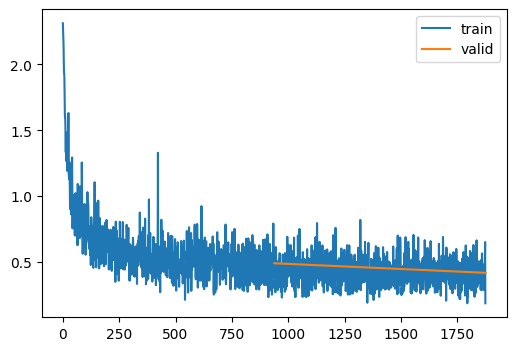

In [30]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## Final Learner

`contextlib.context_manager` has a surprising "feature" which doesn't let us raise an exception before the `yield`, therefore replacing the context manager with a decorator in this updated version of `Learner`. Also added a few more callbacks in `one_epoch()`.

In [31]:
class with_cbs:
    def __init__(self, nm):
        self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']:
                pass
            finally:
                o.callback(f'cleanup_{self.nm}')
        return _f

In [32]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl):
            self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train:
                self.one_epoch(True)
            if valid:
                torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None:
                lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'):
            return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm):
        run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self):
        return self.model.training

## TrainLearner and MomentumLearner

In [33]:
class TrainLearner(Learner):
    def predict(self):
        self.preds = self.model(self.batch[0])
    def get_loss(self):
        self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self):
        self.loss.backward()
    def step(self):
        self.opt.step()
    def zero_grad(self):
        self.opt.zero_grad()

In [34]:
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters():
                p.grad *= self.mom

accuracy,loss,epoch,train
0.801,0.553,0,train
0.818,0.510,0,eval


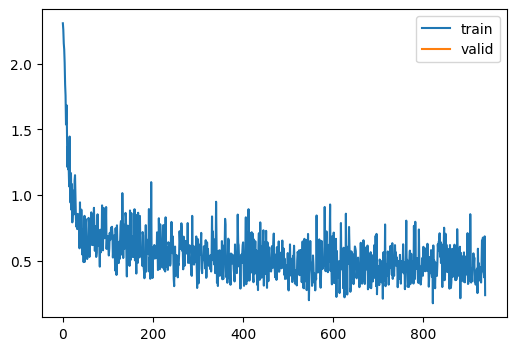

In [35]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(1)

## LRFinderCB

[ExponentialLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR)

Decays the learning rate of each parameter group by gamma every epoch. When `last_epoch=-1`, sets initial lr as lr.

**Parameters**

**optimizer** (Optimizer) – Wrapped optimizer.

**gamma** (`float`) – Multiplicative factor of learning rate decay.

**last_epoch** (`int`) – The index of last epoch. Default: -1.

**verbose** (`bool` | `str`) –

If `True`, prints a message to `stdout` for each update. Default: `False`.

In [36]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3):
        store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training:
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if loss > self.min*3:
            raise CancelFitException()
        for g in learn.opt.param_groups:
            g['lr'] *= self.lr_mult

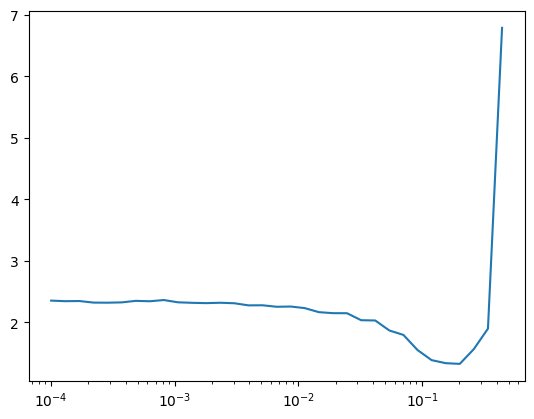

In [37]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale('log')

In [38]:
from torch.optim.lr_scheduler import ExponentialLR

class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3):
        store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: 
            raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min:
            self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

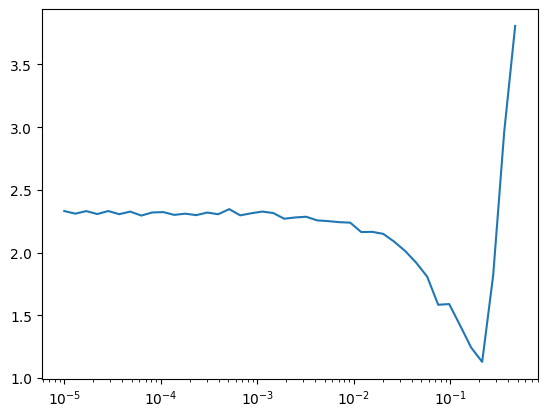

In [39]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

In [40]:
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

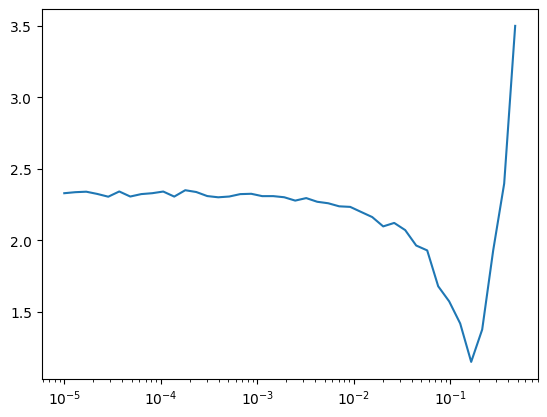

In [41]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()